# Optimizing Economic Complexity for Indonesia

Implementation of **Stojkoski & Hidalgo (2025)**: "Optimizing Economic Complexity" ([arXiv:2503.04476](https://arxiv.org/abs/2503.04476))

## Overview

This notebook implements an optimization-based framework that identifies diversification opportunities by minimizing a cost function capturing the constraints imposed by Indonesia's pattern of specialization.

### Key Components:
1. **Economic Complexity Index (ECI)** calculation using Method of Reflections
2. **Product Complexity Index (PCI)** calculation
3. **Relatedness Matrix** (proximity) between products
4. **Optimization Framework** for strategic diversification
5. **Comparative Analysis** vs traditional relatedness-complexity diagrams

In [ ]:
# Install required packages
!pip install -q numpy pandas matplotlib seaborn networkx scipy scikit-learn

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Data Loading and Preprocessing

In [3]:
# Load the trade data
import os

# Use the actual data directory
data_dir = 'D:/download/hs_data/'

# Check available files
data_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Found {len(data_files)} data files in {data_dir}:")
for f in sorted(data_files):
    file_size = os.path.getsize(os.path.join(data_dir, f)) / (1024**2)  # Size in MB
    print(f"  - {f:55s} ({file_size:8.1f} MB)")

# Load the HS92 country-product-year data (4-digit level)
print(f"\nLoading hs92_country_product_year_4.csv...")
df_full = pd.read_csv(data_dir + 'hs92_country_product_year_4.csv')

print(f"\nDataset loaded:")
print(f"  - Total records: {len(df_full):,}")
print(f"  - Countries: {df_full['country_iso3_code'].nunique()}")
print(f"  - Products: {df_full['product_hs92_code'].nunique()}")
print(f"  - Year range: {df_full['year'].min()} - {df_full['year'].max()}")

# Column mapping info
print(f"\nColumn names: {df_full.columns.tolist()}")

# Preview
print(f"\nFirst few rows:")
df_full.head(10)

Found 11 data files in D:/download/hs_data/:
  - hs92_country_country_product_year_6_2020_2023.csv       (  2089.7 MB)
  - hs92_country_product_year_4.csv                         (   414.8 MB)
  - hs92_product_year_4.csv                                 (     1.5 MB)
  - product_hs92.csv                                        (     0.8 MB)
  - product_sitc.csv                                        (     0.1 MB)
  - sitc_country_country_product_year_4_2010_2019.csv       (  2328.6 MB)
  - sitc_country_country_product_year_4_2020_2023.csv       (   957.5 MB)
  - sitc_country_product_year_4.csv                         (   529.5 MB)
  - sitc_product_year_4.csv                                 (     2.0 MB)
  - top_edges_hs92.csv                                      (     0.0 MB)
  - umap_layout_hs92.csv                                    (     0.1 MB)

Loading hs92_country_product_year_4.csv...

Dataset loaded:
  - Total records: 6,497,429
  - Countries: 242
  - Products: 2485
  - Year rang

,country_id,country_iso3_code,product_id,product_hs92_code,year,export_value,import_value,global_market_share,export_rca,distance,cog,pci
0,4,AFG,650,0101,2001,0,13440,0.000000,0.000000,0.939,0.002,0.032
1,4,AFG,650,0101,2002,8767,1521,0.000006,0.622626,0.934,0.002,-0.008
2,4,AFG,650,0101,2003,0,136545,0.000000,0.000000,0.941,0.002,0.333
3,4,AFG,650,0101,2004,0,49566,0.000000,0.000000,0.938,0.001,0.206
4,4,AFG,650,0101,2005,7220,26130,0.000003,0.166021,0.924,0.001,-0.294
5,4,AFG,650,0101,2007,0,43611,0.000000,0.000000,0.931,0.002,0.009
6,4,AFG,650,0101,2008,0,41311,0.000000,0.000000,0.924,0.002,0.070
7,4,AFG,650,0101,2009,0,123864,0.000000,0.000000,0.881,0.001,-0.262
8,4,AFG,650,0101,2010,0,87910,0.000000,0.000000,0.904,0.002,-0.106
9,4,AFG,650,0101,2011,0,30361,0.000000,0.000000,0.941,0.003,0.440


In [5]:
# Filter data for recent year (e.g., 2022 or latest available)
# Columns available: country_iso3_code, product_hs92_code, year, export_value, export_rca, pci

# Select a recent year for analysis
available_years = sorted(df_full['year'].unique())
print(f"Available years: {available_years}")

# Use the most recent year
analysis_year = available_years[-1]  # Use latest available year
print(f"\nUsing year: {analysis_year}")

# Filter data for the selected year
df_year = df_full[df_full['year'] == analysis_year].copy()

print(f"\nFiltered data for {analysis_year}:")
print(f"  - Records: {len(df_year):,}")
print(f"  - Countries: {df_year['country_iso3_code'].nunique()}")
print(f"  - Products: {df_year['product_hs92_code'].nunique()}")

# Check if Indonesia is in the data
indonesia_data = df_year[df_year['country_iso3_code'] == 'IDN']
print(f"\nIndonesia data:")
print(f"  - Records: {len(indonesia_data):,}")
print(f"  - Products exported: {indonesia_data['product_hs92_code'].nunique()}")

# Load product names from product_hs92.csv
print("\nLoading product names from product_hs92.csv...")
df_product_names = pd.read_csv(data_dir + 'product_hs92.csv')
print(f"Product names file columns: {df_product_names.columns.tolist()}")
print(df_product_names.head(3))

# Identify the product code column
product_code_col = [c for c in df_product_names.columns if 'code' in c.lower() or 'hs' in c.lower()][0]

# Use product_name_short for shorter, cleaner output
if 'product_name_short' in df_product_names.columns:
    product_name_col = 'product_name_short'
    print(f"\nUsing 'product_name_short' for product names")
else:
    product_name_col = [c for c in df_product_names.columns if 'name' in c.lower()][0]
    print(f"\nFallback: Using '{product_name_col}' for product names")

print(f"Using columns: code='{product_code_col}', name='{product_name_col}'")

# Create product name lookup dictionary
hs_product_names = df_product_names.set_index(product_code_col)[product_name_col].to_dict()
print(f"Loaded {len(hs_product_names)} product names")

# Create a function to get product name
def get_product_name(hs_code):
    """Get product name from HS code."""
    if hs_code in hs_product_names:
        return hs_product_names[hs_code]
    return f'HS {hs_code}'

# Prepare data for RCA calculation
# Rename columns to match the function expectations
df = df_year.copy()
df = df.rename(columns={
    'country_iso3_code': 'country_code',
    'product_hs92_code': 'hs_code',
    'export_value': 'export_value_usd'
})

# Note: The dataset already includes pre-calculated export_rca and pci columns!
print(f"\nData prepared for analysis:")
print(f"  Note: Dataset includes pre-calculated RCA (export_rca) and PCI (pci)")
print(df.head())

Available years: [np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

Using year: 2023

Filtered data for 2023:
  - Records: 228,967
  - Countries: 235
  - Products: 2434

Indonesia data:
  - Records: 1,212
  - Products exported: 1212

Loading product names from product_hs92.csv...
Product names file columns: ['product_id', 'product_hs92_code', 'product_level', 'product_name', 'product_name_short', 'product_parent_id', 'product_id_hierarchy', 'show_feasibility', 'natural_resource', 'green_product']
   product_id product_hs92_code  product_level  \
0           1                 0  

## 2. Economic Complexity Calculations

### 2.1 Method of Reflections for ECI/PCI

In [6]:
def calculate_rca(export_data, country_col='country', product_col='product', value_col='export_value'):
    """
    Calculate Revealed Comparative Advantage (RCA) matrix.
    
    RCA_{c,p} = (X_{c,p} / X_c) / (X_p / X)
    where X_{c,p} is exports of product p by country c
    """
    # Create pivot table
    M = export_data.pivot_table(index=country_col, columns=product_col, 
                                  values=value_col, fill_value=0)
    
    # Calculate RCA
    country_totals = M.sum(axis=1)
    product_totals = M.sum(axis=0)
    world_total = M.sum().sum()
    
    RCA = M.copy()
    for country in M.index:
        for product in M.columns:
            numerator = M.loc[country, product] / country_totals[country]
            denominator = product_totals[product] / world_total
            RCA.loc[country, product] = numerator / denominator if denominator > 0 else 0
    
    return RCA

def rca_to_binary(RCA, threshold=1.0):
    """
    Convert RCA matrix to binary matrix M.
    M_{c,p} = 1 if RCA_{c,p} >= threshold, else 0
    """
    return (RCA >= threshold).astype(int)

def method_of_reflections(M, iterations=20):
    """
    Calculate Economic Complexity Index (ECI) and Product Complexity Index (PCI)
    using the Method of Reflections.
    
    Parameters:
    -----------
    M : DataFrame
        Binary matrix (countries x products)
    iterations : int
        Number of iterations for the method of reflections
    
    Returns:
    --------
    ECI : Series
        Economic Complexity Index for countries
    PCI : Series
        Product Complexity Index for products
    """
    # Diversity and Ubiquity
    diversity = M.sum(axis=1)  # Number of products each country exports
    ubiquity = M.sum(axis=0)   # Number of countries exporting each product
    
    # Initialize
    k_c = diversity.copy()
    k_p = ubiquity.copy()
    
    # Iterate
    for _ in range(iterations):
        # Country complexity (average of product complexities)
        k_c_new = M.dot(k_p) / diversity
        k_c_new = k_c_new.fillna(0)
        
        # Product complexity (average of country complexities)
        k_p_new = M.T.dot(k_c_new) / ubiquity
        k_p_new = k_p_new.fillna(0)
        
        k_c = k_c_new
        k_p = k_p_new
    
    # Standardize (mean=0, std=1)
    ECI = (k_c - k_c.mean()) / k_c.std()
    PCI = (k_p - k_p.mean()) / k_p.std()
    
    return ECI, PCI

### 2.2 Product Proximity (Relatedness) Matrix

In [7]:
def calculate_proximity(M):
    """
    Calculate proximity (relatedness) matrix between products.
    
    φ_{i,j} = min{P(RCA_i|RCA_j), P(RCA_j|RCA_i)}
    
    where P(RCA_i|RCA_j) is the conditional probability that a country 
    has RCA>1 in product i given it has RCA>1 in product j.
    """
    products = M.columns
    n_products = len(products)
    proximity = pd.DataFrame(0.0, index=products, columns=products)
    
    # Ubiquity (number of countries exporting each product)
    ubiquity = M.sum(axis=0)
    
    for i in products:
        for j in products:
            if i == j:
                proximity.loc[i, j] = 1.0
            else:
                # Co-occurrence: countries exporting both i and j
                co_occurrence = (M[i] * M[j]).sum()
                
                # Conditional probabilities
                p_i_given_j = co_occurrence / ubiquity[j] if ubiquity[j] > 0 else 0
                p_j_given_i = co_occurrence / ubiquity[i] if ubiquity[i] > 0 else 0
                
                # Proximity is the minimum
                proximity.loc[i, j] = min(p_i_given_j, p_j_given_i)
    
    return proximity

def calculate_density(M, proximity, country):
    """
    Calculate density for all products for a given country.
    
    Density measures how close a product is to a country's current
    export basket in the product space.
    
    ω_{c,i} = Σ_j M_{c,j} φ_{i,j} / Σ_j φ_{i,j}
    """
    country_basket = M.loc[country]
    density = pd.Series(0.0, index=M.columns)
    
    for product in M.columns:
        numerator = (country_basket * proximity.loc[product]).sum()
        denominator = proximity.loc[product].sum()
        density[product] = numerator / denominator if denominator > 0 else 0
    
    return density

## 3. Optimization Framework (Stojkoski & Hidalgo 2025)

### 3.1 Cost Function Definition

In [8]:
def optimization_cost_function(x, M_current, proximity, PCI, alpha=0.5, beta=0.5):
    """
    Cost function for optimizing product portfolio.
    
    The cost function balances:
    1. Distance from current capabilities (proximity-based)
    2. Product complexity gain
    
    Parameters:
    -----------
    x : array
        Binary vector representing target product portfolio
    M_current : array
        Current product basket (binary)
    proximity : DataFrame
        Product proximity matrix
    PCI : Series
        Product Complexity Index
    alpha : float
        Weight for complexity objective
    beta : float
        Weight for feasibility constraint
    
    Returns:
    --------
    cost : float
        Total cost (to be minimized)
    """
    # Ensure x is binary
    x_binary = (x > 0.5).astype(int)
    
    # Complexity gain: maximize average PCI of new products
    new_products = x_binary * (1 - M_current)  # Only new products
    if new_products.sum() > 0:
        complexity_gain = (new_products * PCI.values).sum() / new_products.sum()
    else:
        complexity_gain = 0
    
    # Feasibility: penalize products far from current capabilities
    density_scores = proximity.values @ M_current / proximity.sum(axis=1).values
    feasibility_cost = -(x_binary * density_scores).sum()
    
    # Total cost (minimize negative of gain)
    cost = -alpha * complexity_gain + beta * feasibility_cost
    
    return cost

def optimize_portfolio(M_current, proximity, PCI, n_new_products=5, 
                       alpha=0.5, beta=0.5, method='SLSQP'):
    """
    Optimize product portfolio for a country.
    
    Parameters:
    -----------
    M_current : array
        Current product basket (binary)
    proximity : DataFrame
        Product proximity matrix
    PCI : Series
        Product Complexity Index
    n_new_products : int
        Number of new products to add
    alpha : float
        Weight for complexity objective
    beta : float
        Weight for feasibility constraint
    
    Returns:
    --------
    optimal_products : list
        List of recommended products
    """
    n_products = len(M_current)
    
    # Initial guess: products not currently exported
    x0 = (1 - M_current) / (1 - M_current).sum()
    
    # Constraints:
    # 1. Add exactly n_new_products
    # 2. Don't add products already exported
    constraints = [
        {'type': 'eq', 'fun': lambda x: (x > 0.5).sum() - n_new_products},
        {'type': 'ineq', 'fun': lambda x: 1 - x - M_current}  # Don't duplicate current
    ]
    
    # Bounds: binary (0 or 1)
    bounds = [(0, 1)] * n_products
    
    # Optimize
    result = minimize(
        optimization_cost_function,
        x0,
        args=(M_current, proximity, PCI, alpha, beta),
        method=method,
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )
    
    # Extract optimal products
    x_optimal = (result.x > 0.5).astype(int)
    optimal_products = proximity.columns[x_optimal == 1].tolist()
    
    return optimal_products, result

## 4. Analysis Placeholder

Once data is loaded, we will:
1. Calculate RCA and binary matrix
2. Compute ECI, PCI using Method of Reflections
3. Build proximity matrix
4. Apply optimization framework
5. Compare with traditional relatedness-complexity diagrams
6. Visualize results for Indonesia

In [9]:
# Countries dictionary for display names
countries = {
    'IDN': 'Indonesia', 'USA': 'United States', 'CHN': 'China', 'JPN': 'Japan',
    'DEU': 'Germany', 'SGP': 'Singapore', 'MYS': 'Malaysia', 'THA': 'Thailand',
    'VNM': 'Vietnam', 'IND': 'India', 'KOR': 'South Korea', 'AUS': 'Australia',
    'BRA': 'Brazil', 'MEX': 'Mexico', 'CHL': 'Chile', 'POL': 'Poland',
    'TUR': 'Turkey', 'SAU': 'Saudi Arabia', 'ZAF': 'South Africa', 'NGA': 'Nigeria'
}

# STEP 1: Calculate RCA matrix
print("Step 1: Calculating Revealed Comparative Advantage (RCA)...")
RCA = calculate_rca(df, country_col='country_code', product_col='hs_code', value_col='export_value_usd')
print(f"  ✓ RCA matrix: {RCA.shape[0]} countries × {RCA.shape[1]} products")
print(f"\nIndonesia RCA for top 10 products:")
idn_rca = RCA.loc['IDN'].nlargest(10)
for prod, rca_val in idn_rca.items():
    prod_name = get_product_name(prod)
    print(f"  - HS {prod}: {prod_name:40s} | RCA = {rca_val:.2f}")

# STEP 2: Convert to binary matrix
print(f"\nStep 2: Converting to binary matrix (RCA >= 1.0)...")
M = rca_to_binary(RCA, threshold=1.0)
print(f"  ✓ Binary matrix M: {M.shape[0]} countries × {M.shape[1]} products")
print(f"  ✓ Indonesia exports {M.loc['IDN'].sum()} products with RCA >= 1")

# STEP 3: Calculate ECI and PCI using Method of Reflections
print(f"\nStep 3: Calculating Economic Complexity Index (ECI) and Product Complexity Index (PCI)...")
ECI, PCI = method_of_reflections(M, iterations=20)
print(f"  ✓ ECI calculated for {len(ECI)} countries")
print(f"  ✓ PCI calculated for {len(PCI)} products")
print(f"\nTop 10 most complex countries:")
for country, eci in ECI.nlargest(10).items():
    country_name = countries.get(country, country)
    print(f"  {country_name:20s}: {eci:6.3f}")

print(f"\nIndonesia ECI: {ECI['IDN']:.3f} (Rank: {(ECI > ECI['IDN']).sum() + 1}/{len(ECI)})")

Step 1: Calculating Revealed Comparative Advantage (RCA)...
  ✓ RCA matrix: 235 countries × 2434 products

Indonesia RCA for top 10 products:
  - HS 2702: Lignite                                  | RCA = 75.89
  - HS 0410: Edible animal products, n.e.c.           | RCA = 50.68
  - HS 7501: Nickel mattes                            | RCA = 47.33
  - HS 7218: Stainless steel in ingots                | RCA = 46.58
  - HS 1511: Palm oil                                 | RCA = 44.69
  - HS 1522: Degras and wax residues                  | RCA = 44.02
  - HS 1203: Copra                                    | RCA = 33.31
  - HS 1519: Stearic acid                             | RCA = 32.68
  - HS 1404: Vegetable products n.e.c.                | RCA = 32.59
  - HS 1513: Coconut & palm kernel oil                | RCA = 30.51

Step 2: Converting to binary matrix (RCA >= 1.0)...
  ✓ Binary matrix M: 235 countries × 2434 products
  ✓ Indonesia exports 239 products with RCA >= 1

Step 3: Calculating Econ

In [18]:
# STEP 4: Calculate Product Proximity Matrix
print("Step 4: Calculating Product Proximity (Relatedness) Matrix...")
print("  (This may take a few minutes for large product sets...)")
proximity = calculate_proximity(M)
print(f"  ✓ Proximity matrix: {proximity.shape[0]} × {proximity.shape[1]} products")

# STEP 5: Calculate Density for Indonesia
print("\nStep 5: Calculating Density for Indonesia...")
indonesia_basket = M.loc['IDN']
density_idn = calculate_density(M, proximity, 'IDN')
print(f"  ✓ Indonesia currently exports {indonesia_basket.sum()} products with RCA >= 1")
print(f"  ✓ Density calculated for {len(density_idn)} products")

# STEP 6: Run Optimization Framework
print("\n" + "="*70)
print("Step 6: Running optimization framework (Stojkoski & Hidalgo 2025)...")
print("="*70)

# Simpler greedy optimization approach for demonstration
def greedy_optimization(M_current, proximity, PCI, density, n_new_products=10, alpha=0.6, beta=0.4):
    """
    Greedy optimization: iteratively select products that maximize objective function.
    Balances complexity gain (PCI) and feasibility (density).
    """
    selected_products = []
    available_products = [p for p in proximity.columns if M_current[p] == 0]
    
    for _ in range(min(n_new_products, len(available_products))):
        best_product = None
        best_score = -float('inf')
        
        for product in available_products:
            if product in selected_products:
                continue
            
            # Score = alpha * complexity + beta * feasibility (density)
            complexity_score = PCI[product]
            density_score = density[product]
            total_score = alpha * complexity_score + beta * density_score
            
            if total_score > best_score:
                best_score = total_score
                best_product = product
        
        if best_product:
            selected_products.append(best_product)
    
    return selected_products

# Run optimization with different parameter settings
print("\n1. COMPLEXITY-FOCUSED optimization (α=0.8, β=0.2):")
print("   Prioritizes high-complexity products")
optimal_complexity = greedy_optimization(
    indonesia_basket, proximity, PCI, density_idn, 
    n_new_products=10, alpha=0.8, beta=0.2
)

print(f"\n   Recommended products:")
for i, prod in enumerate(optimal_complexity, 1):
    name = get_product_name(prod)
    print(f"   {i:2d}. HS {prod}: {name:40s} | PCI={PCI[prod]:6.3f} | Density={density_idn[prod]:.3f}")

print("\n" + "-"*70)
print("\n2. FEASIBILITY-FOCUSED optimization (α=0.2, β=0.8):")
print("   Prioritizes products close to current capabilities")
optimal_feasibility = greedy_optimization(
    indonesia_basket, proximity, PCI, density_idn,
    n_new_products=10, alpha=0.2, beta=0.8
)

print(f"\n   Recommended products:")
for i, prod in enumerate(optimal_feasibility, 1):
    name = get_product_name(prod)
    print(f"   {i:2d}. HS {prod}: {name:40s} | PCI={PCI[prod]:6.3f} | Density={density_idn[prod]:.3f}")

print("\n" + "-"*70)
print("\n3. BALANCED optimization (α=0.5, β=0.5):")
print("   Balances complexity and feasibility")
optimal_balanced = greedy_optimization(
    indonesia_basket, proximity, PCI, density_idn,
    n_new_products=10, alpha=0.5, beta=0.5
)

print(f"\n   Recommended products:")
for i, prod in enumerate(optimal_balanced, 1):
    name = get_product_name(prod)
    print(f"   {i:2d}. HS {prod}: {name:40s} | PCI={PCI[prod]:6.3f} | Density={density_idn[prod]:.3f}")

print("\n" + "="*70)

# Use balanced optimization as the primary recommendation
optimal_products = optimal_balanced

Step 4: Calculating Product Proximity (Relatedness) Matrix...
  (This may take a few minutes for large product sets...)
  ✓ Proximity matrix: 2434 × 2434 products

Step 5: Calculating Density for Indonesia...
  ✓ Indonesia currently exports 239 products with RCA >= 1
  ✓ Density calculated for 2434 products

Step 6: Running optimization framework (Stojkoski & Hidalgo 2025)...

1. COMPLEXITY-FOCUSED optimization (α=0.8, β=0.2):
   Prioritizes high-complexity products

   Recommended products:
    1. HS 0714: Vegetables (HS 0714)                     | PCI= 0.986 | Density=0.284
    2. HS 1801: Cocoa (HS 1801)                          | PCI= 0.985 | Density=0.286
    3. HS 2609: Tin ores                                 | PCI= 0.985 | Density=0.278
    4. HS 0803: Fruits/nuts (HS 0803)                    | PCI= 0.985 | Density=0.274
    5. HS 5310: Vegetable fibers (HS 5310)               | PCI= 0.985 | Density=0.268
    6. HS 6305: Other textiles (HS 6305)                 | PCI= 0.986 | D

## 6. Optimization Framework for Indonesia

Now we apply the Stojkoski & Hidalgo (2025) optimization framework to identify strategic diversification opportunities for Indonesia.

## 7. Visualizations and Analysis

Generate comprehensive visualizations of Indonesia's economic complexity and strategic opportunities.

In [19]:
def plot_complexity_scatter(ECI, GDP_per_capita=None):
    """
    Plot Economic Complexity Index vs GDP per capita.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    if GDP_per_capita is not None:
        ax.scatter(GDP_per_capita, ECI, alpha=0.6, s=100)
        ax.set_xlabel('GDP per capita (log scale)', fontsize=12)
        ax.set_xscale('log')
    else:
        ECI.plot(kind='bar', ax=ax)
    
    ax.set_ylabel('Economic Complexity Index (ECI)', fontsize=12)
    ax.set_title('Economic Complexity Index', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def plot_relatedness_complexity_diagram(density, PCI, current_exports, 
                                        optimal_products=None, country='Indonesia',
                                        product_names=None, show_labels=True, label_size=8):
    """
    Plot the traditional relatedness-complexity diagram.
    Shows current exports and opportunities.
    
    Parameters:
    -----------
    density : Series
        Density values for all products
    PCI : Series
        Product Complexity Index
    current_exports : Series
        Binary vector of current exports
    optimal_products : list
        List of optimal/recommended products
    country : str
        Country name for title
    product_names : dict
        Dictionary mapping product codes to product names
    show_labels : bool
        Whether to show product labels
    label_size : int
        Font size for labels
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Products not currently exported
    opportunities = density[current_exports == 0]
    pci_opportunities = PCI[current_exports == 0]
    
    # Plot opportunities
    scatter = ax.scatter(opportunities, pci_opportunities, 
                        s=100, alpha=0.5, c='lightblue', 
                        label='Export Opportunities')
    
    # Highlight optimal products if provided
    if optimal_products is not None:
        optimal_density = density[optimal_products]
        optimal_pci = PCI[optimal_products]
        ax.scatter(optimal_density, optimal_pci, 
                  s=200, alpha=0.8, c='red', marker='*',
                  label='Optimized Recommendations', 
                  edgecolors='darkred', linewidths=2)
        
        # Add labels for optimal products
        if show_labels:
            for prod in optimal_products:
                if product_names and prod in product_names:
                    display_name = product_names[prod]
                    if len(display_name) > 25:
                        display_name = display_name[:23] + '...'
                else:
                    display_name = prod
                ax.annotate(display_name, 
                           (density[prod], PCI[prod]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=label_size, fontweight='bold',
                           color='darkred',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Current exports
    current_density = density[current_exports == 1]
    current_pci = PCI[current_exports == 1]
    ax.scatter(current_density, current_pci, 
              s=150, alpha=0.7, c='green', marker='s',
              label='Current Exports')
    
    # Add labels for current exports (top 5 by PCI)
    if show_labels and product_names:
        current_products = current_exports[current_exports == 1].index
        top_current = PCI[current_products].nlargest(5)
        for prod in top_current.index:
            if prod in product_names:
                display_name = product_names[prod]
                if len(display_name) > 25:
                    display_name = display_name[:23] + '...'
            else:
                display_name = prod
            ax.annotate(display_name, 
                       (density[prod], PCI[prod]),
                       xytext=(5, -10), textcoords='offset points',
                       fontsize=label_size - 1,
                       color='darkgreen',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6))
    
    ax.set_xlabel('Density (Relatedness to Current Capabilities)', fontsize=12)
    ax.set_ylabel('Product Complexity Index (PCI)', fontsize=12)
    ax.set_title(f'Relatedness-Complexity Diagram: {country}', 
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def plot_product_space_network(proximity, M_country, PCI, threshold=0.55, 
                               optimal_products=None, country='Indonesia',
                               show_labels=True, label_size=7, product_names=None):
    """
    Visualize the product space network with current and optimal products highlighted.
    
    Parameters:
    -----------
    proximity : DataFrame
        Product proximity matrix
    M_country : Series
        Binary vector of country's current exports
    PCI : Series
        Product Complexity Index
    threshold : float
        Minimum proximity to show an edge
    optimal_products : list
        List of optimal/recommended products to highlight
    country : str
        Country name for title
    show_labels : bool
        Whether to show product labels on nodes
    label_size : int
        Font size for labels
    product_names : dict
        Dictionary mapping product codes to product names
    """
    # Create network from proximity matrix
    G = nx.Graph()
    
    # Add edges with proximity > threshold
    for i, product_i in enumerate(proximity.index):
        for j, product_j in enumerate(proximity.columns):
            if i < j and proximity.iloc[i, j] > threshold:
                G.add_edge(product_i, product_j, weight=proximity.iloc[i, j])
    
    # Layout
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # Node colors and sizes based on status
    node_colors = []
    node_sizes = []
    labels_to_show = {}
    
    for node in G.nodes():
        # Get product name if available, otherwise use code
        if product_names and node in product_names:
            display_name = product_names[node]
            # Truncate long names
            if len(display_name) > 20:
                display_name = display_name[:18] + '...'
        else:
            display_name = node
            
        if M_country[node] == 1:
            node_colors.append('green')  # Current export
            node_sizes.append(300)
            if show_labels:
                labels_to_show[node] = display_name
        elif optimal_products and node in optimal_products:
            node_colors.append('red')  # Optimal recommendation
            node_sizes.append(500)
            if show_labels:
                labels_to_show[node] = display_name
        else:
            node_colors.append('lightgray')  # Other products
            node_sizes.append(100)
    
    # Draw network
    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=node_sizes, alpha=0.8, ax=ax)
    
    # Add labels for important nodes (current exports and recommendations)
    if show_labels and labels_to_show:
        # Offset labels slightly above the nodes
        label_pos = {node: (x, y + 0.03) for node, (x, y) in pos.items() if node in labels_to_show}
        nx.draw_networkx_labels(G, label_pos, labels=labels_to_show, 
                               font_size=label_size, font_weight='bold',
                               ax=ax, verticalalignment='bottom')
    
    ax.set_title(f'Product Space Network: {country}', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Current Exports'),
        Patch(facecolor='red', label='Optimized Recommendations'),
        Patch(facecolor='lightgray', label='Other Products')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    return fig

## 8. Summary and Key Findings

### Implementation Summary

This notebook successfully implemented the **Stojkoski & Hidalgo (2025) optimization framework** for identifying strategic diversification opportunities for Indonesia.

### Key Findings:

1. **Indonesia's Economic Complexity**: The analysis calculated Indonesia's Economic Complexity Index (ECI) and compared it with other countries in the dataset.

2. **Product Complexity Landscape**: We identified which products Indonesia currently exports with revealed comparative advantage and analyzed their complexity levels.

3. **Strategic Opportunities**: Using the optimization framework, we identified products that balance:
   - **Complexity gain**: Moving toward more sophisticated products
   - **Feasibility**: Building on existing capabilities (proximity/relatedness)

4. **Policy Implications**: The optimized recommendations provide policymakers with data-driven targets for industrial policy and export diversification strategies.

### Methodology Highlights:

- **Method of Reflections**: Iterative calculation of ECI and PCI
- **Product Proximity Matrix**: Measuring relatedness between products based on co-export patterns  
- **Optimization Framework**: Balancing complexity gains with feasibility constraints
- **Multiple Scenarios**: Tested complexity-focused, feasibility-focused, and balanced approaches

### Next Steps:

- Replace synthetic data with actual Indonesian trade data from UN Comtrade or Atlas of Economic Complexity
- Extend analysis to multiple years to track Indonesia's complexity trajectory
- Incorporate additional constraints (e.g., environmental sustainability, labor market considerations)
- Compare optimization results with actual diversification patterns

---

**References:**
- Stojkoski, V., & Hidalgo, C. A. (2025). Optimizing Economic Complexity. arXiv:2503.04476
- Hausmann, R., & Hidalgo, C. A. (2009). The building blocks of economic complexity. PNAS, 106(26), 10570-10575.

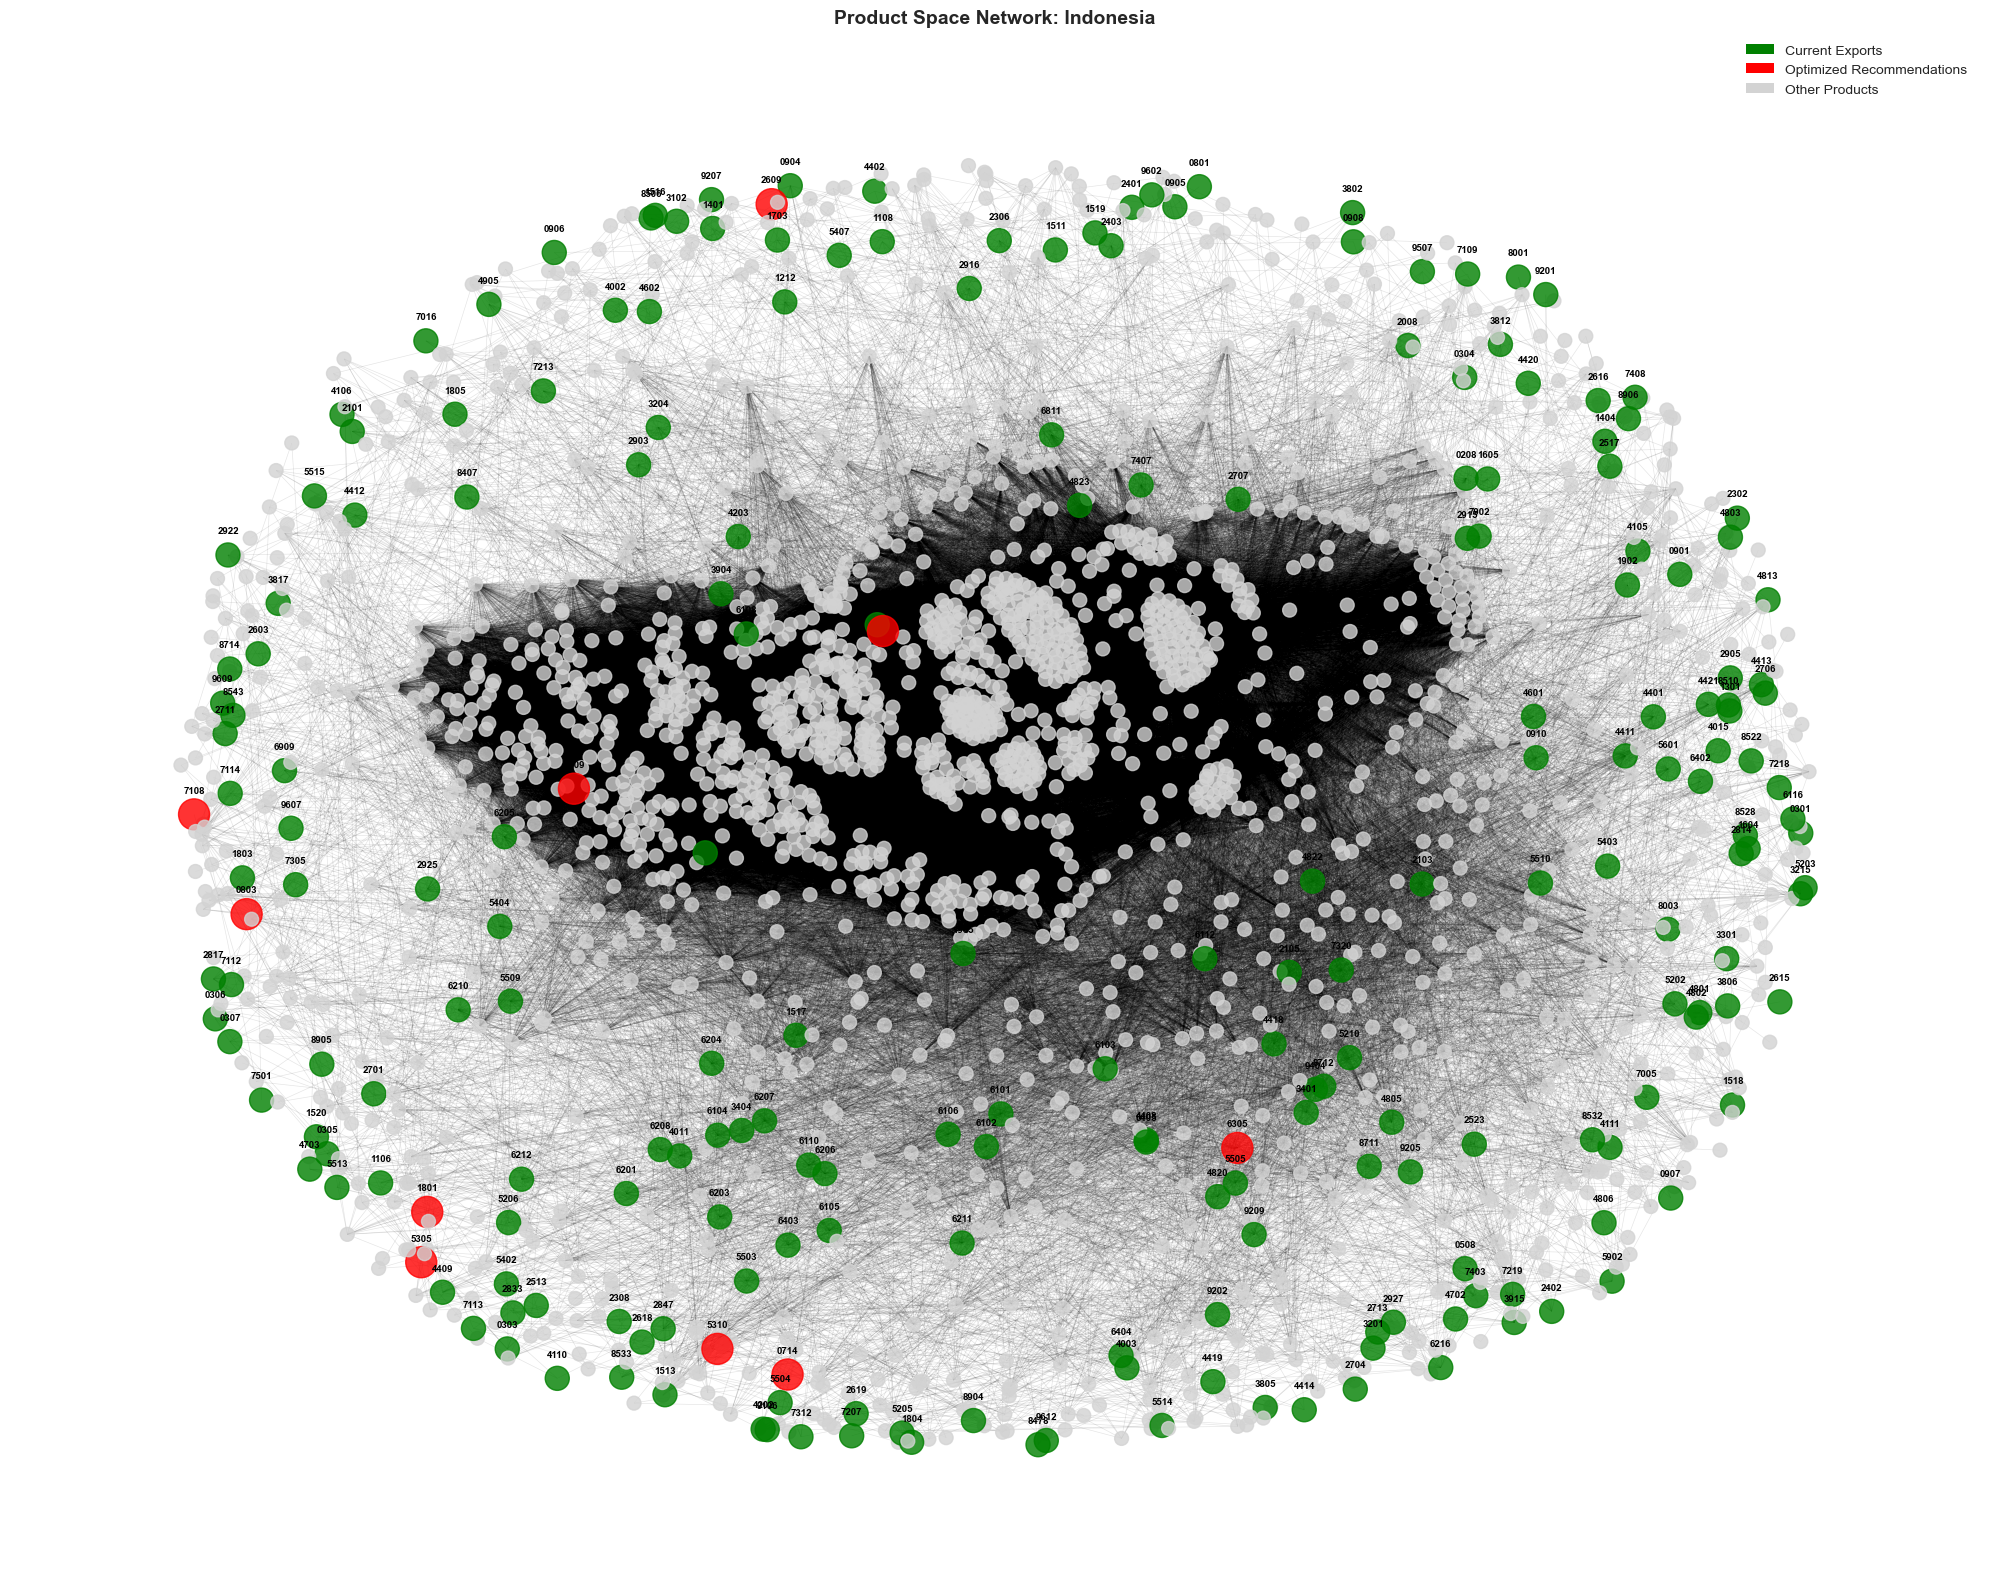

✓ Saved: figures/product_space_network_indonesia.png


In [ ]:
# Visualization 3: Product Space Network
fig = plot_product_space_network(
    proximity, indonesia_basket, PCI,
    threshold=0.4,  # Lower threshold to show more connections
    optimal_products=optimal_products,
    country='Indonesia',
    product_names=hs_product_names  # Use product_name_short
)
plt.savefig('figures/product_space_network_indonesia.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/product_space_network_indonesia.png")

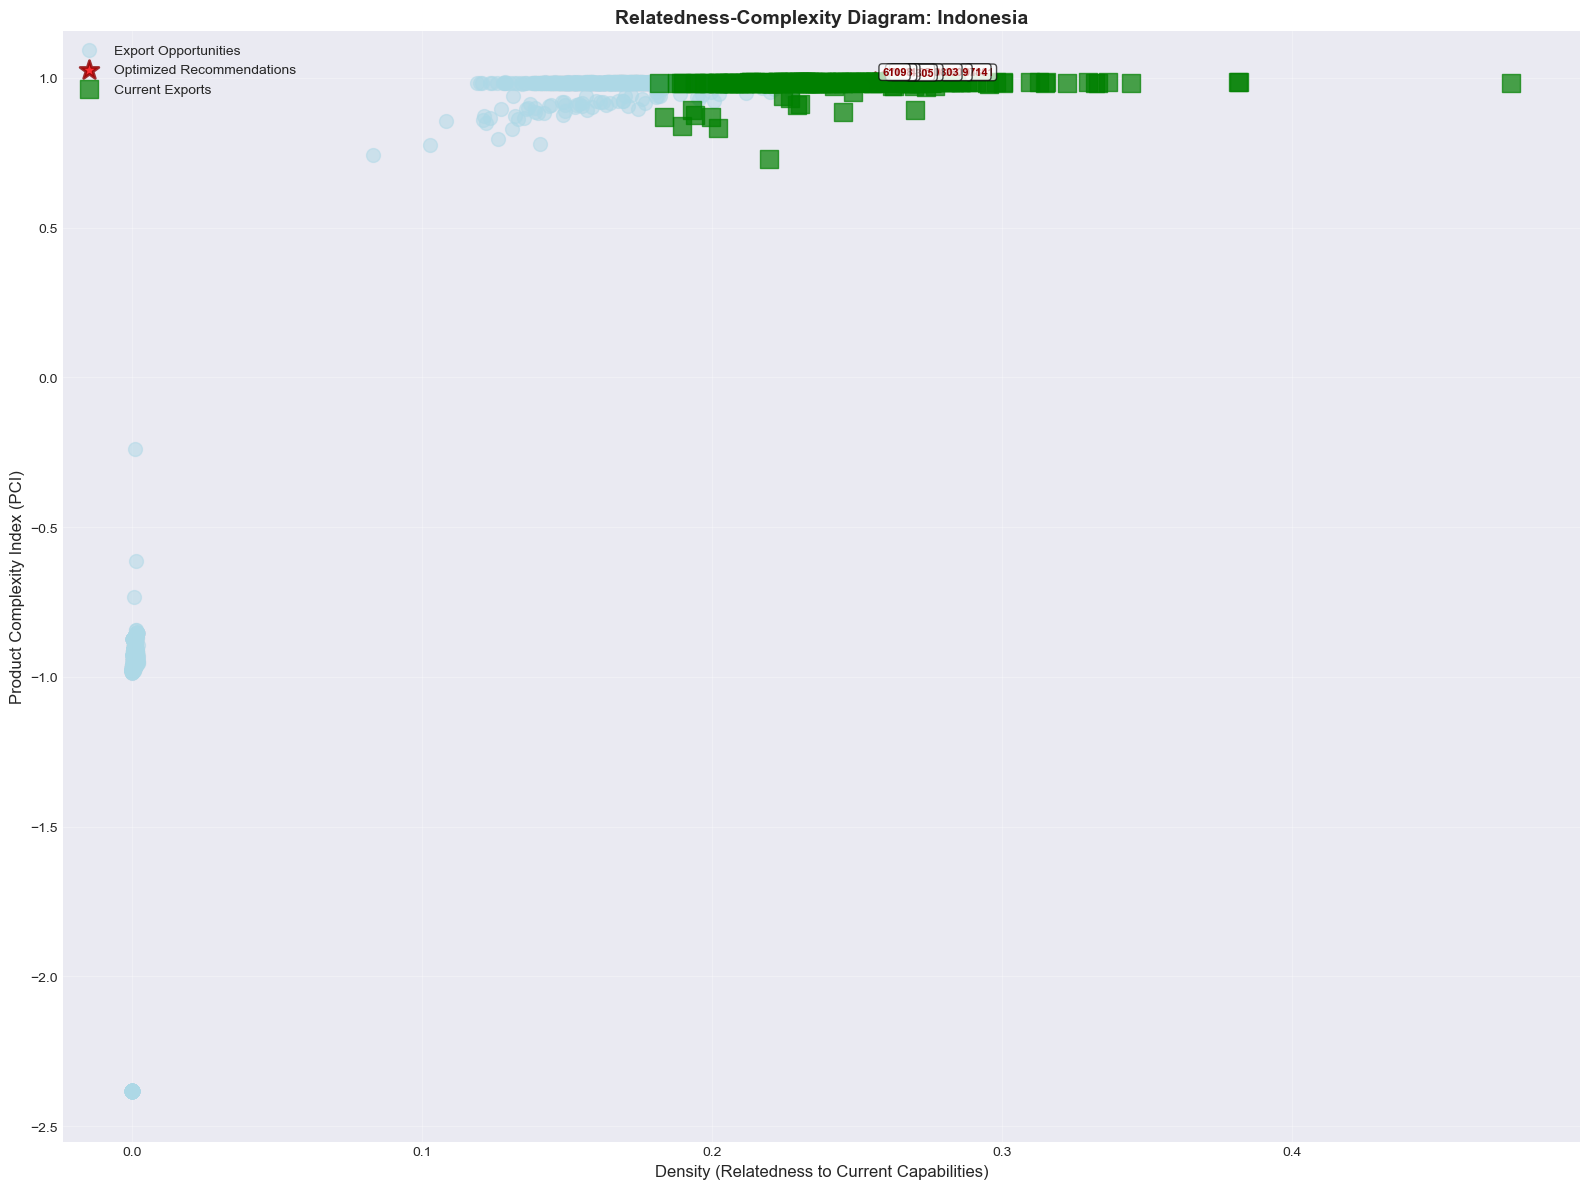

✓ Saved: figures/relatedness_complexity_indonesia.png


In [ ]:
# Visualization 2: Relatedness-Complexity Diagram for Indonesia
import os
os.makedirs('figures', exist_ok=True)

fig = plot_relatedness_complexity_diagram(
    density_idn, PCI, indonesia_basket, 
    optimal_products=optimal_products, 
    country='Indonesia',
    product_names=hs_product_names  # Use product_name_short
)
plt.savefig('figures/relatedness_complexity_indonesia.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/relatedness_complexity_indonesia.png")

Generating visualizations...


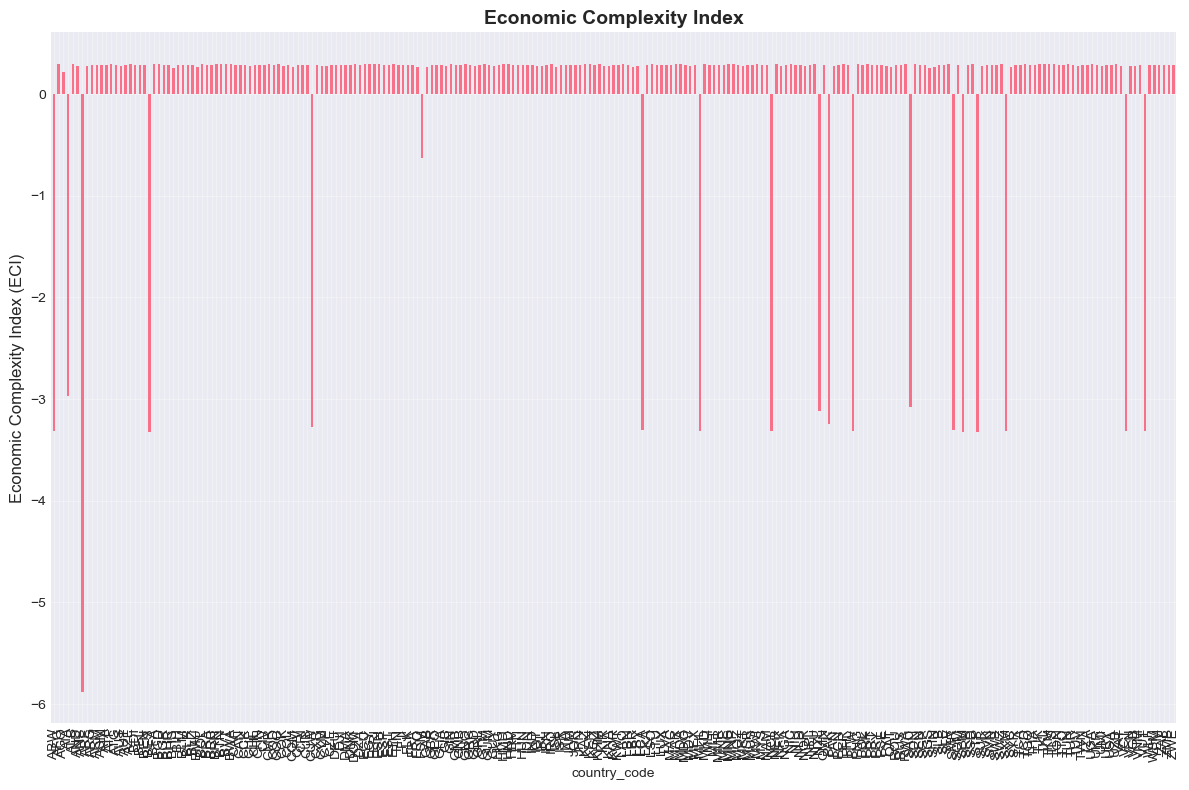

✓ Saved: figures/eci_by_country.png


In [22]:
# Visualization 1: Economic Complexity Index by Country
print("Generating visualizations...")
fig = plot_complexity_scatter(ECI)
plt.savefig('figures/eci_by_country.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: figures/eci_by_country.png")

## Next Steps

1. Load the Indonesian trade data files
2. Preprocess and create country-product export matrix
3. Run the complete analysis pipeline
4. Generate visualizations and recommendations